## BMI-206 Course Project
### Group 3 
#### Members:
- Xintong (Zoe) Chen
- Isobel Beasley
- Abolfazl (Abe) Arab

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from glob import glob

In [2]:
def read_multiple_files(files):
    
    dfs = {}

    for name, file in files:
        df = pd.read_csv(file, sep='\t', header=0).dropna(axis=1, how='all')
        print(name, df.shape)
        df.insert(df.shape[-1], column='source', value=name)
        dfs[name] = df

    return dfs

___

### GWAS data and analysis
[issue link](https://github.com/abearab/BMI-206-Class-Project/issues/2)

___
First, running @IJbeasley codes to gather fine-mapping data from the GWAS catalog.

In [3]:
# !bash code/finemap/download_finemap.sh 

In [4]:
fine_map_df = pd.read_csv(
    "data/fine_map/all_finngen_trait_cs_filtered.tsv",
    sep='\t'
)

fine_map_df['seqnames'] = fine_map_df['region'].str.split(':').str[0]
fine_map_df['starts'] =  fine_map_df['region'].str.split(':').str[1].str.split('-').str[0].astype(int)
fine_map_df['ends'] =    fine_map_df['region'].str.split(':').str[1].str.split('-').str[1].astype(int)

fine_map_df = fine_map_df.set_index(['seqnames', 'starts', 'ends']).reset_index()

The columns were best explained here: https://github.com/FINNGEN/finemapping-pipeline?tab=readme-ov-file#phenonamesusiesnpfiltertsv

___

#### Fig 4. a-c
(GWAS Manhattan plot by @IJbeasley)

In [5]:
##################### Figure 4a. ################# 

# 6q15
# 93100001-99500000 hg19 ucsc browser
# 92390283-99052124 liftover from hg19 to hg38
# in hg38 88000001-93100000 ucsc browser


######################## Figure 4 b. ####################### 
# 4p15.2

# 21300001-27700000 hg19
# 21298378-27698378 hg38


##################### Figure 4c ######################### 
# 11p14.1
# hg38 liftover 27178454-30978453
# hg19 27200001-31000000

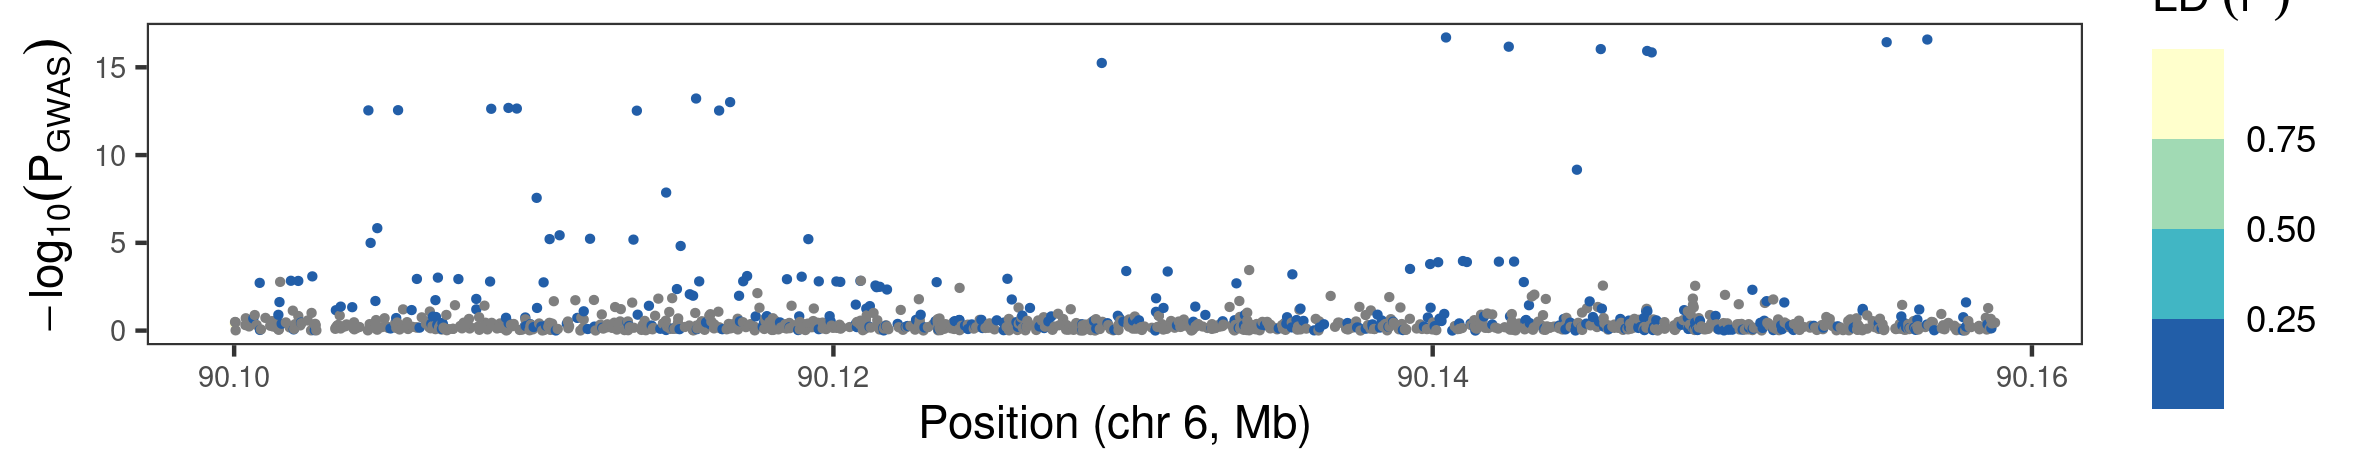

In [6]:
%matplotlib inline
from IPython.display import Image

# show a png file
Image(filename='figures/t1d_uk_bb.h.filt.fig4a.png')

### Single-cell data and analysis
[issue link](https://github.com/abearab/BMI-206-Class-Project/issues/3)

data: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE243917

___
R Scripts

In [7]:
# suppressMessages(suppressWarnings(library('SCENT')))
# suppressMessages(suppressWarnings(library('Seurat')))
# suppressMessages(suppressWarnings(library('SingleCellExperiment')))
# suppressMessages(suppressWarnings(library('tidyverse')))
# suppressMessages(suppressWarnings(library('anndata')))

In [8]:
# library('Matrix')

In [9]:
# # Create SingleCellExperiment objects that points to on-disk H5AD file
# rna_h5ad_file = 'data/GSE243917_genesXcells_ALL_raw.h5ad'
# atac_h5ad_file = 'data/GSE243917_peaksXcells_ALL_raw.h5ad'

# rna <- anndata::read_h5ad(rna_h5ad_file)
# atac <- anndata::read_h5ad(atac_h5ad_file)

# # Convert to dgCMatrix using Matrix package
# rna$X <- Matrix(rna$X, "dgCMatrix")
# atac$X <- Matrix(atac$X, "dgCMatrix")

In [10]:
# SCENT_obj <- SCENT::CreateSCENTObj(
#     rna = rna$X,
#     atac = atac$X,
#     meta.data = rna$obs,
#     peak.info = atac$obs,
#     covariates = c("log(nUMI)","percent.mito","sample", "batch"), 
#     celltypes = "ct" # cell type column
# )

___

| Column | Descriptions | 
| ------ | ------------ |
| gene | The gene(-peak) pair in each test statistics
| peak | The (gene-)peak pair in each test statistics
| beta | The regression coefficient from primary Poisson regression
| se | The standard error from primary Poisson regression
| z | The Z score from primary Poisson regression
| p | The raw p value from primary Poisson regression
| boot_basic_p | The bootstrap p value calculated from bootstrapping analyses

In [11]:
def read_scent_output(file):
    
    res = pd.read_csv(file, sep=' ')

    res['seqnames'] = res['peak'].str.split(':').str[0]
    res['starts'] = res['peak'].str.split(':').str[1].str.split('-').str[0].astype(int)
    res['ends'] = res['peak'].str.split(':').str[1].str.split('-').str[1].astype(int)

    res['-log10(p)'] = -np.log10(res['p'])
    res['-log10(boot_basic_p)'] = -np.log10(res['boot_basic_p'])

    res = res.set_index(['seqnames', 'starts', 'ends','peak','gene']).reset_index()

    res.index = res['peak'] + '::' + res['gene']

    return res

In [12]:
ls data/scent-results/

500kb_fibroblast_allcvar_part.txt.gz  500kb_Tcell_nocvar_parts.txt.gz
500kb_Tcell_allcvar.txt.gz


In [13]:
res_Tcell_allcvar = read_scent_output('data/scent-results/500kb_Tcell_allcvar.txt.gz')
res_Tcell_nocvar = read_scent_output('data/scent-results/500kb_Tcell_nocvar_parts.txt.gz')
res_fibroblast_allcvar_part = read_scent_output('data/scent-results/500kb_fibroblast_allcvar_part.txt.gz')

/pollard/home/aabe/miniconda3/envs/SCENT/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/pollard/home/aabe/miniconda3/envs/SCENT/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/pollard/home/aabe/miniconda3/envs/SCENT/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [14]:
# fine_map_df.groupby('trait').size().sort_values(ascending=False)

In [15]:
print('Number of fine-mapped regions:', fine_map_df.shape[0])
print('Number of unique traits:', fine_map_df['trait'].nunique())

Number of fine-mapped regions: 2663
Number of unique traits: 795


In [16]:
fine_map_df.query(
    'seqnames == "chr6" and starts >= 90 * 10**6 and ends <= 90.3 * 10**6'
)

,seqnames,starts,ends,trait,region,v,cs,cs_specific_prob,chromosome,position,allele1,allele2,maf,beta,p,se,most_severe,gene_most_severe


In [17]:
res_Tcell_allcvar.query(
    'seqnames == "chr6" and starts >= 90 * 10**6 and ends <= 90.3 * 10**6 and gene == "BACH2"'
)

,seqnames,starts,ends,peak,gene,beta,se,z,p,boot_basic_p,-log10(p),-log10(boot_basic_p)
chr6:90080937-90081137::BACH2,chr6,90080937,90081137,chr6:90080937-90081137,BACH2,0.334452,0.017441,19.175763,5.899626e-82,0.00004,81.229176,4.397940
chr6:90081170-90081370::BACH2,chr6,90081170,90081370,chr6:90081170-90081370,BACH2,0.346913,0.019435,17.850034,2.888585e-71,0.00004,70.539315,4.397940
chr6:90103494-90103694::BACH2,chr6,90103494,90103694,chr6:90103494-90103694,BACH2,0.300484,0.023503,12.784854,1.992367e-37,0.00004,36.700631,4.397940
chr6:90234047-90234247::BACH2,chr6,90234047,90234247,chr6:90234047-90234247,BACH2,0.479856,0.019962,24.038582,1.099013e-127,0.00004,126.958997,4.397940
chr6:90274493-90274693::BACH2,chr6,90274493,90274693,chr6:90274493-90274693,BACH2,0.390684,0.014536,26.876827,4.098743e-159,0.00004,158.387349,4.397940
chr6:90284334-90284534::BACH2,chr6,90284334,90284534,chr6:90284334-90284534,BACH2,0.214471,0.021332,10.054154,8.807433e-24,0.00004,23.055151,4.397940
chr6:90284751-90284951::BACH2,chr6,90284751,90284951,chr6:90284751-90284951,BACH2,0.143390,0.017409,8.236660,1.770850e-16,0.00104,15.751818,2.982967
chr6:90285685-90285885::BACH2,chr6,90285685,90285885,chr6:90285685-90285885,BACH2,0.102682,0.021089,4.869006,1.121610e-06,0.04160,5.950158,1.380907
chr6:90295185-90295385::BACH2,chr6,90295185,90295385,chr6:90295185-90295385,BACH2,0.081502,0.021779,3.742245,1.823834e-04,0.16000,3.739015,0.795880
chr6:90295409-90295609::BACH2,chr6,90295409,90295609,chr6:90295409-90295609,BACH2,0.150422,0.021603,6.963177,3.326839e-12,0.00584,11.477968,2.233587


In [18]:
# set(fine_map_df['region']) & set(res_1['peak'].to_list())

In [19]:
# # bed file
# # columns: chr, start, end, p
# res_1_bed = pd.concat(
#     {
#         'chr':res_1['peak'].str.split(':').str[0],
#         'start':res_1['peak'].str.split(':').str[1].str.split('-').str[0].astype(int),
#         'end':res_1['peak'].str.split(':').str[1].str.split('-').str[1].astype(int),
#         'name':res_1['gene']+'::'+res_1['peak'],
#         'score':res_1['beta'],
#         # 'strand':pd.Series('.',index=res_1.index),
#     },axis=1
# )

In [20]:
# res_1_bed.to_csv('data/zoe-scent-results/500kb_Tcell_allcvar.bed', sep='\t', index=False, header=False)

In [21]:
# res_1 = res_Tcell_allcvar

# # draw volcano plot of z vs -log10(p) and color by source

# fig, axes = plt.subplots(2,2, figsize=(9,9))

# res_1.plot.scatter(x='z', y='-log10(boot_basic_p)', alpha=0.5, ax=axes[0,0])
# res_1.plot.scatter(x='beta', y='-log10(boot_basic_p)', alpha=0.5, ax=axes[0,1])
# res_1.plot.scatter(x='z', y='-log10(p)', alpha=0.5, ax=axes[1,0])
# res_1.plot.scatter(x='beta', y='-log10(p)', alpha=0.5, ax=axes[1,1])

# plt.suptitle('500kb_Tcell_allcvar', fontsize=20)
# plt.tight_layout()
# plt.show()

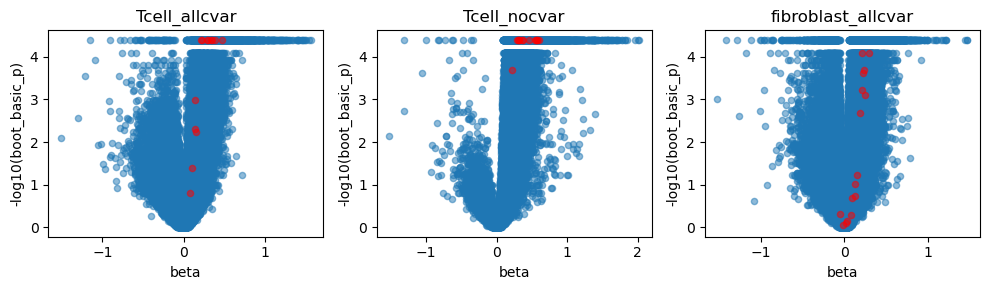

In [22]:
fig, axes = plt.subplots(1,3, figsize=(10,3))


for i, (name, res) in enumerate({
    'Tcell_allcvar':res_Tcell_allcvar,
    'Tcell_nocvar':res_Tcell_nocvar,
    'fibroblast_allcvar':res_fibroblast_allcvar_part,
}.items()): 
    
    res.plot.scatter(x='beta', y='-log10(boot_basic_p)', alpha=0.5, ax=axes[i])
    res.query(
        'seqnames == "chr6" and starts >= 90 * 10**6 and ends <= 90.3 * 10**6 and gene == "BACH2"'
    ).plot.scatter(x='beta', y='-log10(boot_basic_p)', alpha=0.5, ax=axes[i], color='red')

    axes[i].set_title(name)

plt.tight_layout()
plt.show()

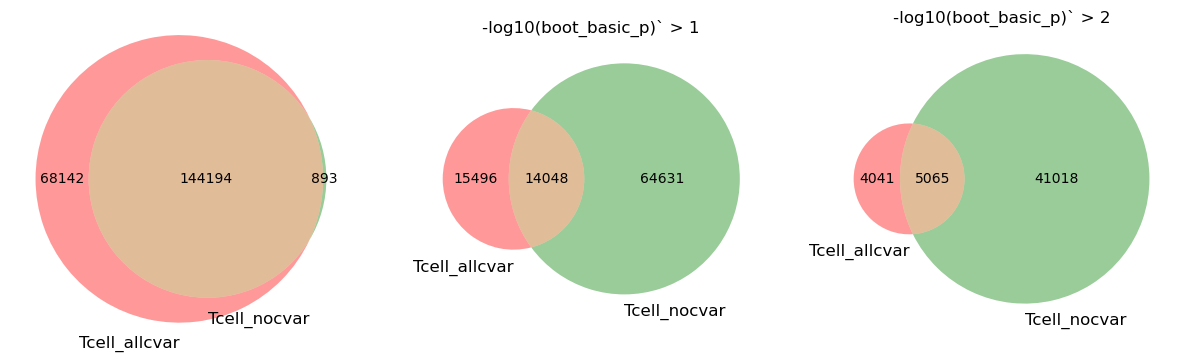

In [23]:
# venn diagram of the number of peaks and overlapping peaks
# Tcell_allcvar and Tcell_nocvar
from matplotlib_venn import venn2

fig, axes = plt.subplots(1,3, figsize=(15,5))
 

venn2(
    subsets = (
        set(res_Tcell_allcvar.index.to_list()),
        set(res_Tcell_nocvar.index.to_list())
    ),
    set_labels=('Tcell_allcvar', 'Tcell_nocvar'),
    ax=axes[0]
)

venn2(
    subsets = (
        set(res_Tcell_allcvar.query('`-log10(boot_basic_p)` > 1').index.to_list()),
        set(res_Tcell_nocvar.query('`-log10(boot_basic_p)` > 1').index.to_list()),
    ),
    set_labels=('Tcell_allcvar', 'Tcell_nocvar'),
    ax=axes[1]
)
axes[1].set_title('-log10(boot_basic_p)` > 1')


venn2(
    subsets = (
        set(res_Tcell_allcvar.query('`-log10(boot_basic_p)` > 2').index.to_list()),
        set(res_Tcell_nocvar.query('`-log10(boot_basic_p)` > 2').index.to_list()),
    ),
    set_labels=('Tcell_allcvar', 'Tcell_nocvar'),
    ax=axes[2]
)
axes[2].set_title('-log10(boot_basic_p)` > 2')


plt.show()

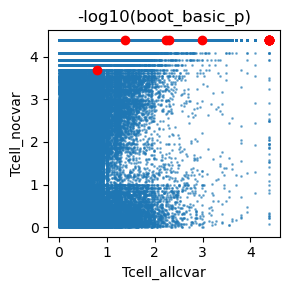

In [24]:
fig, ax = plt.subplots(1,1, figsize=(3,3))


ax.scatter(
    x=res_Tcell_allcvar.loc[
        list(set(res_Tcell_allcvar.index) & set(res_Tcell_nocvar.index)),
        '-log10(boot_basic_p)'
    ],
    y=res_Tcell_nocvar.loc[
        list(set(res_Tcell_allcvar.index) & set(res_Tcell_nocvar.index)),
        '-log10(boot_basic_p)'
    ],
    alpha=0.5,
    s=1
)

ax.scatter(
    x=res_Tcell_allcvar.loc[
        list(set(res_Tcell_allcvar.index) & set(res_Tcell_nocvar.index)),
        :
    ].query(
        'seqnames == "chr6" and starts >= 90 * 10**6 and ends <= 90.3 * 10**6 and gene == "BACH2"'
    )['-log10(boot_basic_p)'],
    y=res_Tcell_nocvar.loc[
        list(set(res_Tcell_allcvar.index) & set(res_Tcell_nocvar.index)),
        :
    ].query(
        'seqnames == "chr6" and starts >= 90 * 10**6 and ends <= 90.3 * 10**6 and gene == "BACH2"'
    )['-log10(boot_basic_p)'],
    # s=3,
    color='red'
)

ax.set_xlabel('Tcell_allcvar')
ax.set_ylabel('Tcell_nocvar')

# ax.set_xlim(-2.1,2.3)
# ax.set_ylim(-2.1,2.3)

plt.title('-log10(boot_basic_p)')
plt.tight_layout()
plt.show()

___
preprocessed files from the SCENT paper:

In [25]:
# files = [
#     (os.path.basename(file).replace('_allqced_bootpkg_nopc_allCT.FDR0.10.txt.gz',''), file)
#     for file in glob('data/enhancer-gene-links-from-the-paper/*.txt.gz')
# ]

In [26]:
# dfs = read_multiple_files(files)

# df = pd.concat(dfs.values())
# df['-log10(p)'] = -np.log10(df['p'])
# df['-log10(boot_p)'] = -np.log10(df['boot_p'])

In [27]:
# fig, ax = plt.subplots(figsize=(5,5))

# df.plot.scatter(
#     x='beta', y='-log10(boot_p)', 
#     alpha=0.5, 
#     c=df['source'].astype('category').cat.codes, 
#     cmap='tab20', 
#     ax=ax
# )

# plt.show()

### Enrichment analysis
[issue link](https://github.com/abearab/BMI-206-Class-Project/issues/5)

**Aim:** Causal variant enrichment analysis

**Tasks:**
- ~Reimplement enrichment analysis similar to the SCENT paper~
- [x] Run region permutation enrichment analysis 

related links:
- https://biocpy.github.io/GenomicRanges/tutorial.html#overlap-based-methodsm

___
From our proposal:
> To replicate and expand upon the paper’s disease enrichment analysis of the causal variants identified with SCENT, we will create a set of disease causal variants by filtering the FinnGen fine-mapping results for the most reliable identified fine-mapped traits (e.g., number of case > 1,000) and variants (high purity of casual sets). 

> To evaluate the SCENT’s outcome, Sakaue et al. defined and evaluated causal enrichment for GWAS, eQTLs, caQTL or other ground truth resources such as bulk or single-cell-based enhancer–gene maps (Fig 3, S6-S8). We found this as a useful part of the paper to focus on for more in-depth statistical analysis. We will implement a “causal variant enrichment analysis” formula through custom codes in R or python. As we move forward, we will decide what exact analysis we can perform. We have lots of examples from the sub-figures but we can also go beyond that, for instance we can evaluate what are the effects of changing covariates in the SCENT pipeline.


<!-- ___

We defined causal variant enrichment statistics for GWAS within SCENT enhancers and other annotations by using statistically fine-mapped variants from FinnGen79 and UK Biobank80 that we described in the previous section. We selected variants with PIP >0.2 as putatively causal variants for primary analyses.

\begin{array}{l}{{{\mathrm{Enrichment}}}}_{{{\mathrm{trait}}}{\rm{\_}}i}\\=\displaystyle\frac{{\!\,}^{\displaystyle{\rm{\#}}{{{\mathrm{causal}}}{\rm{\_}}\mathrm{var}{\rm{\_}}{{\mathrm{in}}}{\rm{\_}}{{\mathrm{annot}}}}_{{{\mathrm{trait}}}{\rm{\_}}i}}\!\left/{\vphantom{\sum^2_8}}{\!\!\,}_{\displaystyle\sum {{{\mathrm{common}}}{\rm{\_}}\mathrm{var}{\rm{\_}}{{\mathrm{in}}}{\rm{\_}}{{\mathrm{annot}}}}_{{{\mathrm{trait}}}{\rm{\_}}i}}\right.}{{\!\,}^{\displaystyle{{\rm{\#}}{{\mathrm{causal}}}{\rm{\_}}\mathrm{var}}_{{{\mathrm{trait}}}{\rm{\_}}i}}\!\left/{\vphantom{\sum^2_8}}{\!\!\,}_{\displaystyle\sum {{{\mathrm{common}}}{\rm{\_}}\mathrm{var}{\rm{\_}}{{\mathrm{across}}}{\rm{\_}}{{\mathrm{loci}}}}_{{{\mathrm{trait}}}{\rm{\_}}i}}\right.}\end{array}


```math
{{\mathrm{Overall}}}{{\,}}{{\mathrm{Enrichment}}}=\frac{1}{n}\mathop{\sum }\limits_{i=1}^{n}{{{\mathrm{Enrichment}}}}_{{{\mathrm{trait}}}{\rm{\_}}i}
```

For each trait i, we divided the number of putatively causal variants within an annotation (across all loci for trait i) normalized by the number of common variants within an annotation by the number of all causal variants for trait i normalized by the number of all common variants within all significant loci analyzed for the trait i. To calculate common variants within annotation or within locus, we again used 1000 Genomes Project variants with minor allele frequency >1% in European population. To derive Overall Enrichment score, we took the mean across all the traits.

For each trait i and putative causal gene pair, we calculated the distance between the TSS of the gene and the most likely causal variant which had the largest PIP when multiple variants were nominated for a single gene by SCENT (Supplementary Fig. 6a). For each putative causal gene for the trait i, we also sorted all the genes on the basis of the distance between the gene’s TSS and the most likely causal variant (from the smallest to the largest). We then obtained the rank of the putative causal gene from SCENT among the sorted gene list to see how often the SCENT gene is the closest gene from the most likely causal variant.

___ -->

- https://github.com/orgs/BiocPy/discussions/9


In [28]:
# from genomicranges import GenomicRanges

# def run_overlap(subject, query):
#     # # find Overlaps
#     # res = subject.find_overlaps(query, query_type="within")
    
#     # # count Overlaps
#     # res = subject.count_overlaps(query)

#     # subset by Overlaps
#     res = subject.subset_by_overlaps(query, query_type="within")

#     return res

In [29]:
import sys

sys.path.append('code')

import regionperm

In [30]:
help(regionperm.run)

Help on function run in module regionperm:

run(A_region_set, B_region_set, universe_region_set, num_iterations, match_by)
    Genomic region association analysis with permutation tests.

    Assess the association between a set of genomic regions and other genomic features using permutation tests.

    Parameters:
    A_region_set: the set of regions to randomize in BED format.
    B_region_set: the set of genomic features that will be analyzed for their association with the regions in A_region_set in BED format.
    universe_region_set: the total valid regions from which subsequent random iterations will be sampled from in BED format. A_region_set is a subset of the universe_region_set.
    num_iterations: number of iterations for permutation test.
    match_by: for each iteration, randomize regions by matching the count or length of the original A region set. choices=['count', 'length']



### run `regionperm` for allcvar vs. nocvar

/pollard/home/aabe/miniconda3/envs/SCENT/lib/python3.12/site-packages/pybedtools/bedtool.py:3687: UserWarning: Default names for filetype bed are:
['chrom', 'start', 'end', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts']
but file has 32 fields; you can supply custom names with the `names` kwarg
  warn(
Permutation simulations in progress: 100% |███████████████████████████████████| 1000/1000 simulation


Original evaluation: 1178
Alternative: greater
P-value: 0.001998001998001998
Z-score: 3.1212424670565757

Done.
Time elapsed: 16.20 minutes.


,p_value,z_score,n_iterations,alternative,original_evaluation,complement_evaluation,universe_evaluation
0,0.001998,3.121242,1000,greater,1178,1195,1204


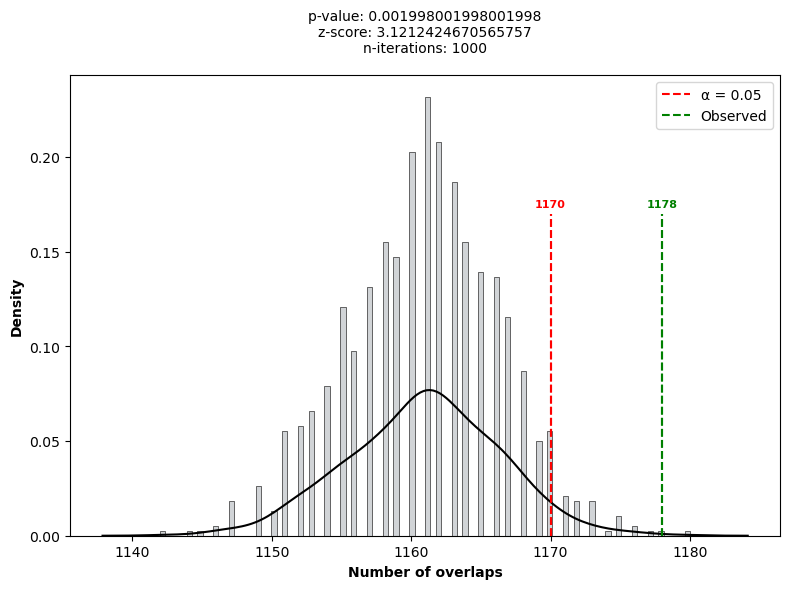

In [51]:
regionperm.run(
    A_region_set = res_Tcell_allcvar.query('`-log10(boot_basic_p)` > 1').copy(), # FDR < 0.1 ?
    B_region_set = fine_map_df,
    universe_region_set = res_Tcell_allcvar,
    num_iterations = 1000,
    match_by = 'count'
)

/pollard/home/aabe/BMI-206-Class-Project/code/regionperm.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['fragment_length'] = df.apply(lambda row: row.iloc[2]-row.iloc[1], axis=1)
/pollard/home/aabe/miniconda3/envs/SCENT/lib/python3.12/site-packages/pybedtools/bedtool.py:3687: UserWarning: Default names for filetype bed are:
['chrom', 'start', 'end', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts']
but file has 32 fields; you can supply custom names with the `names` kwarg
  warn(
Permutation simulations in progress: 100% |███████████████████████████████████| 1000/1000 simulation

Original evaluation: 1149
Alternative: greater
P-value: 0.04495504495504495
Z-score: 1.7065982936820312

Done.
Time elapsed: 23.16 minutes.


,p_value,z_score,n_iterations,alternative,original_evaluation,complement_evaluation,universe_evaluation
0,0.044955,1.706598,1000,greater,1149,992,1151


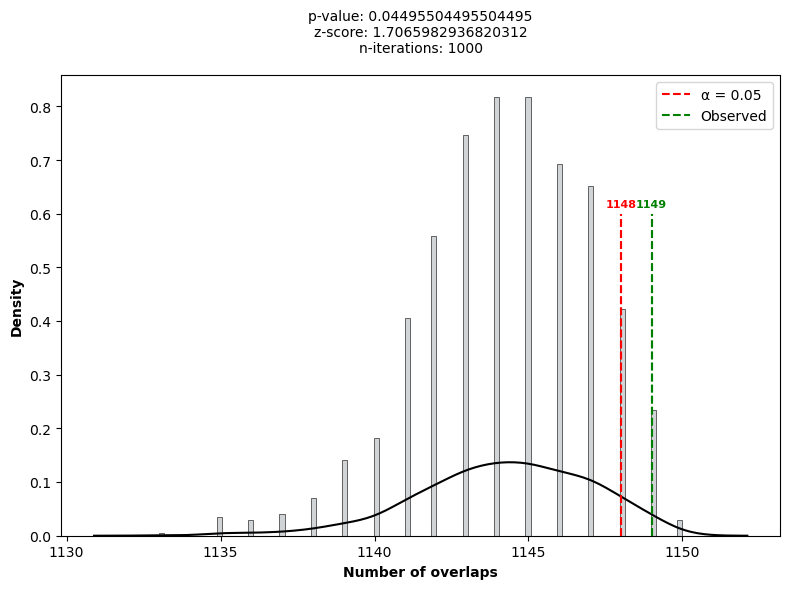

In [52]:
regionperm.run(
    A_region_set = res_Tcell_nocvar.query('`-log10(boot_basic_p)` > 1'), # FDR < 0.1 ?
    B_region_set = fine_map_df,
    universe_region_set = res_Tcell_nocvar,
    num_iterations = 1000,
    match_by = 'count'
)

### run `regionperm` for different FDR cutoffs

/pollard/home/aabe/miniconda3/envs/SCENT/lib/python3.12/site-packages/pybedtools/bedtool.py:3687: UserWarning: Default names for filetype bed are:
['chrom', 'start', 'end', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts']
but file has 32 fields; you can supply custom names with the `names` kwarg
  warn(
Permutation simulations in progress: 100% |█████████████████████████████████████| 100/100 simulation


Original evaluation: 1204
Alternative: less
P-value: 0.04950495049504951
Z-score: 0.19145989526675772

Done.
Time elapsed: 10.78 minutes.


/pollard/home/aabe/miniconda3/envs/SCENT/lib/python3.12/site-packages/pybedtools/bedtool.py:3687: UserWarning: Default names for filetype bed are:
['chrom', 'start', 'end', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts']
but file has 32 fields; you can supply custom names with the `names` kwarg
  warn(
Permutation simulations in progress: 100% |█████████████████████████████████████| 100/100 simulation


Original evaluation: 1178
Alternative: greater
P-value: 0.009900990099009901
Z-score: 3.812598094774976

Done.
Time elapsed: 1.63 minutes.


/pollard/home/aabe/miniconda3/envs/SCENT/lib/python3.12/site-packages/pybedtools/bedtool.py:3687: UserWarning: Default names for filetype bed are:
['chrom', 'start', 'end', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts']
but file has 32 fields; you can supply custom names with the `names` kwarg
  warn(
Permutation simulations in progress: 100% |█████████████████████████████████████| 100/100 simulation


Original evaluation: 1079
Alternative: less
P-value: 0.3465346534653465
Z-score: -0.2962626209672111

Done.
Time elapsed: 0.88 minutes.


/pollard/home/aabe/miniconda3/envs/SCENT/lib/python3.12/site-packages/pybedtools/bedtool.py:3687: UserWarning: Default names for filetype bed are:
['chrom', 'start', 'end', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts']
but file has 32 fields; you can supply custom names with the `names` kwarg
  warn(
Permutation simulations in progress: 100% |█████████████████████████████████████| 100/100 simulation


Original evaluation: 954
Alternative: less
P-value: 0.019801980198019802
Z-score: -2.7724493437553694

Done.
Time elapsed: 1.14 minutes.


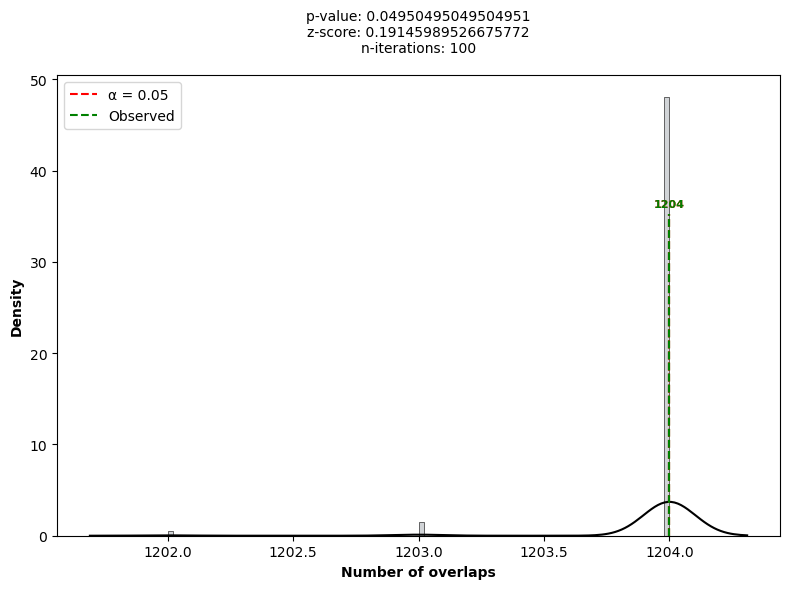

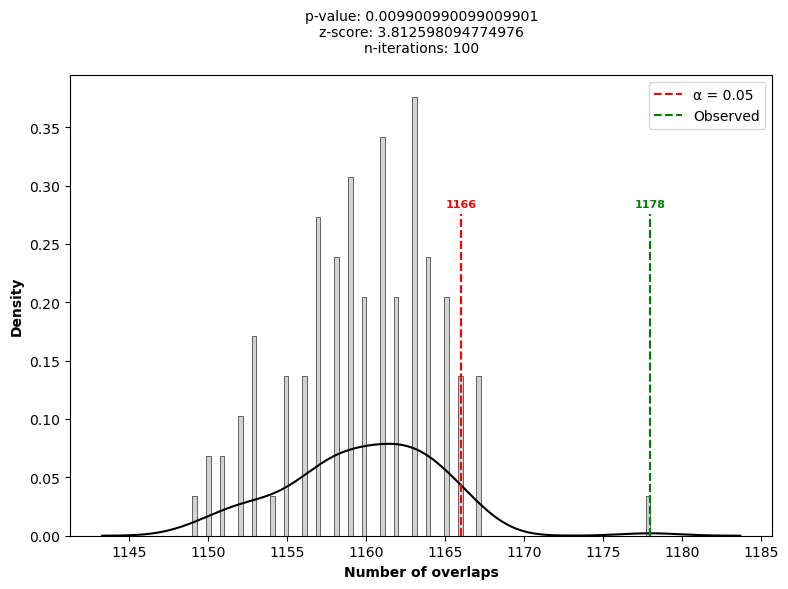

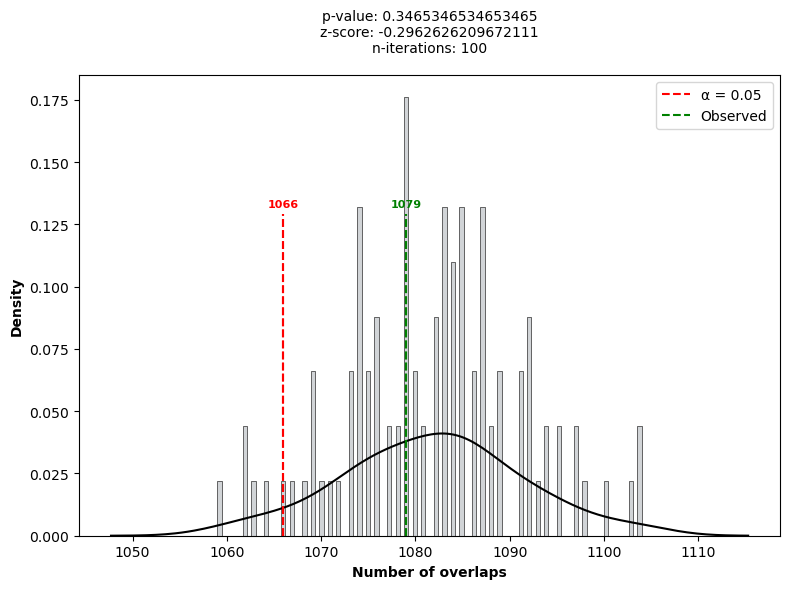

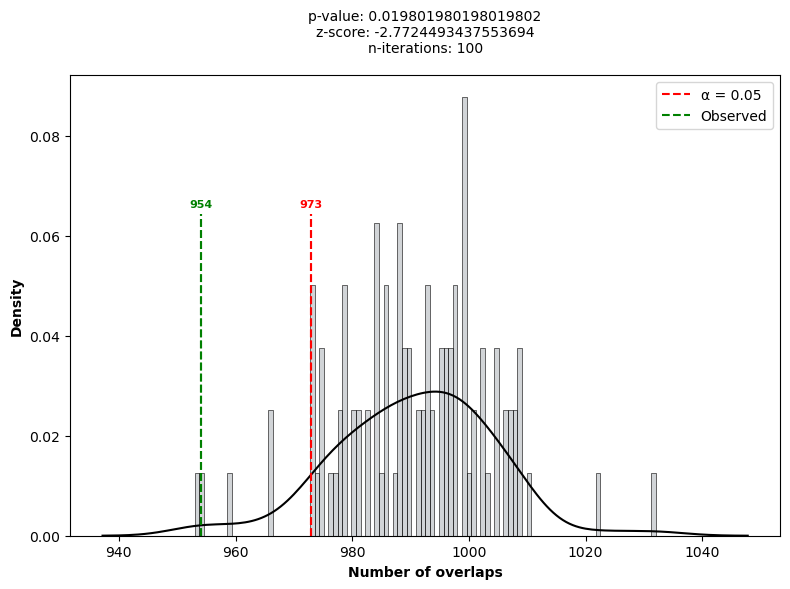

In [53]:
# run regionperm with different FDR cutoffs

regionperm_results_fdrs = []

for thr in [0, 1, 2, 3]:
    
    r = regionperm.run(
        A_region_set = res_Tcell_allcvar.query(f'`-log10(boot_basic_p)` > {thr}').copy(),
        B_region_set = fine_map_df,
        universe_region_set = res_Tcell_allcvar,
        num_iterations = 100,
        match_by = 'count'
    )
    r['FDR_threshold'] = thr
    regionperm_results_fdrs.append(r)

regionperm_results_fdrs = pd.concat(regionperm_results_fdrs)

### run `regionperm` for each trait

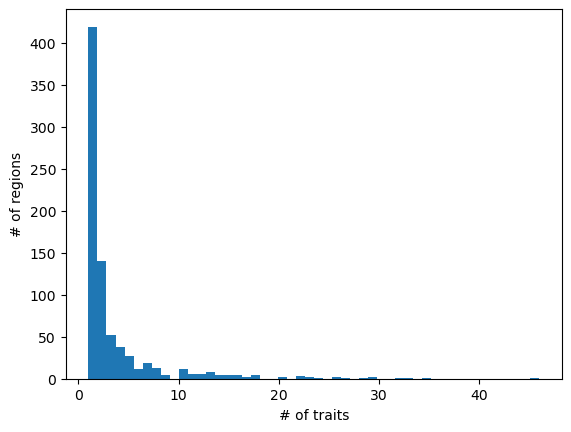

In [56]:
plt.hist(
    [fine_map_trait.shape[0] for trait, fine_map_trait in fine_map_df.groupby('trait')], bins=50
)
plt.ylabel('# of regions')
plt.xlabel('# of traits')
plt.show()

 It seems most traits only have 1 region so I don't think the enrichment analysis per trait would make sense here.

In [55]:
# # run regionperm for each trait

# regionperm_results_trait = []

# for thr in 
    
#     r = regionperm.run(
#         A_region_set = res_Tcell_allcvar.query(f'`-log10(boot_basic_p)` > {thr}').copy(),
#         B_region_set = fine_map_
#         universe_region_set = res_Tcell_allcvar,
#         num_iterations = 100,
#         match_by = 'count'
#     )
#     r['FDR_threshold'] = thr
#     regionperm_results_fdrs.append(r)

# regionperm_results_fdrs = pd.concat(regionperm_results_fdrs)

___

In [1]:
# fine_map_gr = GenomicRanges.from_pandas(fine_map_df)

In [ ]:
# boot_basic_p__threshold = 3

# res_fibroblast_allcvar_part_gr = GenomicRanges.from_pandas(res_fibroblast_allcvar_part.query(f'`-log10(boot_basic_p)` > {boot_basic_p__threshold}'))
# res_Tcell_allcvar_gr = GenomicRanges.from_pandas(res_Tcell_allcvar.query(f'`-log10(boot_basic_p)` > {boot_basic_p__threshold}'))
# res_Tcell_nocvar_gr = GenomicRanges.from_pandas(res_Tcell_nocvar.query(f'`-log10(boot_basic_p)` > {boot_basic_p__threshold}'))

In [ ]:
# for name, res in {
#     'Tcell_allcvar':res_Tcell_allcvar_gr,
#     'Tcell_nocvar':res_Tcell_nocvar_gr,
#     'fibroblast_allcvar':res_fibroblast_allcvar_part_gr,
# }.items():
    
#     ol1 = run_overlap(
#         subject = res,
#         query = fine_map_gr
#     )

#     ol2 = run_overlap(
#         subject = fine_map_gr,
#         query = res
#     )

#     print(f'{name}:\n\t\t{len(ol1)} {len(ol2)}\n')


In [ ]:
# res_Tcell_allcvar_gr

In [ ]:
# res_fibroblast_allcvar_part

In [ ]:
# len(res_fibroblast_allcvar_part_gr), len(res_fibroblast_allcvar_part_overlap)

In [ ]:
# from sklearn.metrics import precision_recall_curve

# # https://www.datacamp.com/tutorial/precision-recall-curve-tutorial

In [ ]:
# precision, recall, thresholds = precision_recall_curve(y_train, y_prob_train)

# plt.fill_between(recall, precision)
# plt.ylabel("Precision")
# plt.xlabel("Recall")
# plt.title("Train Precision-Recall curve")

In [ ]:
# results = []

# for i, row_i in res_Tcell_allcvar.iterrows():
#     for j, row_j in fine_map_df.iterrows():
#         # check if row i is within row j
#         if row_i['seqnames'] == row_j['seqnames'] and row_i['starts'] >= row_j['starts'] and row_i['ends'] <= row_j['ends']:
#             results.append([i, j])

###

In [44]:
%reload_ext watermark
%watermark
%watermark --iversions

Last updated: 2024-11-25T10:19:50.056157-08:00

Python implementation: CPython
Python version       : 3.12.7
IPython version      : 8.29.0

Compiler    : GCC 13.3.0
OS          : Linux
Release     : 4.18.0-477.27.1.el8_8.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 64
Architecture: 64bit

pandas         : 2.2.3
sys            : 3.12.7 | packaged by conda-forge | (main, Oct  4 2024, 16:05:46) [GCC 13.3.0]
matplotlib_venn: 1.1.1
numpy          : 2.0.2
matplotlib     : 3.9.2
IPython        : 8.29.0



___